<a href="https://colab.research.google.com/github/alexisvannson/Deepfake/blob/main/FacesGCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"alexisvannson","key":"9f7e8019a1f9079977e40917c56a4893"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download ashwingupta3012/human-faces

Dataset URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces
License(s): CC0-1.0
human-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir faces
!unzip human-faces.zip -d faces

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: faces/Humans/1 (2910).jpg  
  inflating: faces/Humans/1 (2911).jpg  
  inflating: faces/Humans/1 (2912).jpg  
  inflating: faces/Humans/1 (2913).jpg  
  inflating: faces/Humans/1 (2914).jpg  
  inflating: faces/Humans/1 (2915).jpg  
  inflating: faces/Humans/1 (2916).jpg  
  inflating: faces/Humans/1 (2917).jpg  
  inflating: faces/Humans/1 (2918).jpg  
  inflating: faces/Humans/1 (2919).jpg  
  inflating: faces/Humans/1 (292).jpg  
  inflating: faces/Humans/1 (2920).jpg  
  inflating: faces/Humans/1 (2921).jpg  
  inflating: faces/Humans/1 (2922).jpg  
  inflating: faces/Humans/1 (2923).jpg  
  inflating: faces/Humans/1 (2924).jpg  
  inflating: faces/Humans/1 (2925).jpg  
  inflating: faces/Humans/1 (2926).jpg  
  inflating: faces/Humans/1 (2927).jpg  
  inflating: faces/Humans/1 (2928).jpg  
  inflating: faces/Humans/1 (2929).jpg  
  inflating: faces/Humans/1 (293).jpg  
  inflating: faces/Hum

In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "/content/faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

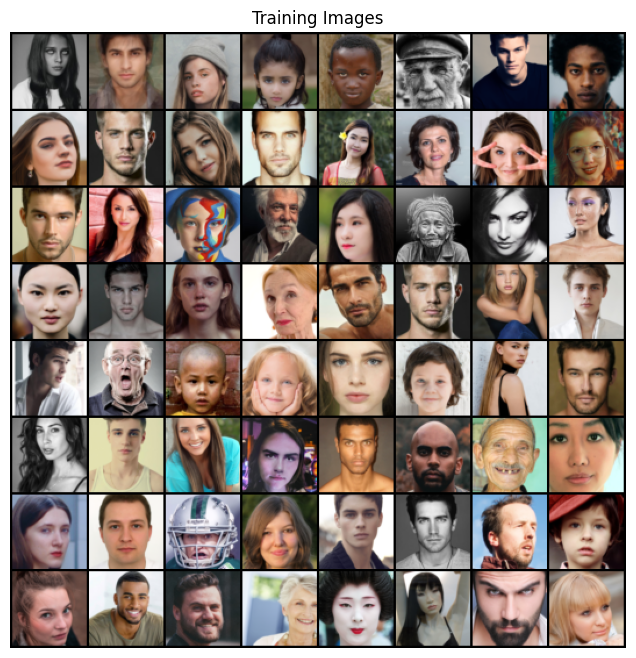

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def save_weights(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, filename='model_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'modelG_state_dict': netG.state_dict(),
        'modelD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
    }, filename)
    print(f"Model weights saved at epoch {epoch}.")


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        # Save model weights every few epochs (e.g., every 5 epochs)
    if epoch % 3 == 0:
        save_weights(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses)

# Final save after training
save_weights(num_epochs, netG, netD, optimizerG, optimizerD, G_losses, D_losses)

Starting Training Loop...
[0/40][0/57]	Loss_D: 1.7247	Loss_G: 5.6816	D(x): 0.5193	D(G(z)): 0.5501 / 0.0055


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/40][10/57]	Loss_D: 0.7174	Loss_G: 8.7880	D(x): 0.8286	D(G(z)): 0.2537 / 0.0003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/40][20/57]	Loss_D: 2.3344	Loss_G: 20.6428	D(x): 0.9438	D(G(z)): 0.8407 / 0.0000
[0/40][30/57]	Loss_D: 0.2798	Loss_G: 18.4634	D(x): 0.8312	D(G(z)): 0.0000 / 0.0000
[0/40][40/57]	Loss_D: 0.4098	Loss_G: 13.5360	D(x): 0.8914	D(G(z)): 0.2036 / 0.0000
[0/40][50/57]	Loss_D: 0.0373	Loss_G: 22.4738	D(x): 0.9736	D(G(z)): 0.0000 / 0.0000
Model weights saved at epoch 0.
[1/40][0/57]	Loss_D: 0.0299	Loss_G: 16.1294	D(x): 0.9723	D(G(z)): 0.0000 / 0.0000
[1/40][10/57]	Loss_D: 0.1987	Loss_G: 22.4318	D(x): 0.9061	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/40][20/57]	Loss_D: 0.0309	Loss_G: 16.1955	D(x): 0.9761	D(G(z)): 0.0000 / 0.0000
[1/40][30/57]	Loss_D: 0.2751	Loss_G: 8.0287	D(x): 0.8613	D(G(z)): 0.0580 / 0.0006


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/40][40/57]	Loss_D: 0.1037	Loss_G: 6.6741	D(x): 0.9653	D(G(z)): 0.0491 / 0.0022
[1/40][50/57]	Loss_D: 0.2661	Loss_G: 5.6146	D(x): 0.8807	D(G(z)): 0.0644 / 0.0073
[2/40][0/57]	Loss_D: 0.5313	Loss_G: 2.2529	D(x): 0.7363	D(G(z)): 0.0282 / 0.2297
[2/40][10/57]	Loss_D: 1.6289	Loss_G: 11.0410	D(x): 0.9587	D(G(z)): 0.7374 / 0.0001


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/40][20/57]	Loss_D: 0.2982	Loss_G: 4.6090	D(x): 0.8820	D(G(z)): 0.1338 / 0.0180
[2/40][30/57]	Loss_D: 1.0624	Loss_G: 7.9888	D(x): 0.9571	D(G(z)): 0.5451 / 0.0018
[2/40][40/57]	Loss_D: 0.7568	Loss_G: 5.1139	D(x): 0.7668	D(G(z)): 0.3144 / 0.0098


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/40][50/57]	Loss_D: 0.4021	Loss_G: 4.1702	D(x): 0.8033	D(G(z)): 0.1057 / 0.0225
[3/40][0/57]	Loss_D: 0.4754	Loss_G: 3.3075	D(x): 0.7259	D(G(z)): 0.0737 / 0.0547


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3/40][10/57]	Loss_D: 0.2949	Loss_G: 3.2861	D(x): 0.8291	D(G(z)): 0.0699 / 0.0476
[3/40][20/57]	Loss_D: 0.4572	Loss_G: 4.3499	D(x): 0.9364	D(G(z)): 0.2883 / 0.0223
[3/40][30/57]	Loss_D: 0.6115	Loss_G: 5.4986	D(x): 0.8328	D(G(z)): 0.2910 / 0.0073
[3/40][40/57]	Loss_D: 0.4397	Loss_G: 2.7966	D(x): 0.8691	D(G(z)): 0.2001 / 0.0957
[3/40][50/57]	Loss_D: 0.4931	Loss_G: 4.0609	D(x): 0.8272	D(G(z)): 0.1988 / 0.0222
Model weights saved at epoch 3.
[4/40][0/57]	Loss_D: 0.3187	Loss_G: 2.9440	D(x): 0.8315	D(G(z)): 0.0793 / 0.0796


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/40][10/57]	Loss_D: 1.3487	Loss_G: 3.0768	D(x): 0.4144	D(G(z)): 0.0223 / 0.0893


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/40][20/57]	Loss_D: 0.4607	Loss_G: 4.2003	D(x): 0.7567	D(G(z)): 0.0436 / 0.0234
[4/40][30/57]	Loss_D: 0.3276	Loss_G: 4.6739	D(x): 0.8410	D(G(z)): 0.0877 / 0.0132
[4/40][40/57]	Loss_D: 0.4452	Loss_G: 4.6801	D(x): 0.7973	D(G(z)): 0.1225 / 0.0134
[4/40][50/57]	Loss_D: 0.5221	Loss_G: 3.7476	D(x): 0.8379	D(G(z)): 0.2114 / 0.0400
[5/40][0/57]	Loss_D: 0.6788	Loss_G: 4.0772	D(x): 0.7641	D(G(z)): 0.2176 / 0.0335


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5/40][10/57]	Loss_D: 1.1309	Loss_G: 5.8056	D(x): 0.8260	D(G(z)): 0.4791 / 0.0070
[5/40][20/57]	Loss_D: 0.5885	Loss_G: 3.0703	D(x): 0.7204	D(G(z)): 0.1073 / 0.0685
[5/40][30/57]	Loss_D: 0.9264	Loss_G: 6.2616	D(x): 0.9407	D(G(z)): 0.5078 / 0.0046
[5/40][40/57]	Loss_D: 0.5721	Loss_G: 3.1105	D(x): 0.7798	D(G(z)): 0.1855 / 0.0793


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5/40][50/57]	Loss_D: 0.6642	Loss_G: 4.8726	D(x): 0.8664	D(G(z)): 0.3455 / 0.0139
[6/40][0/57]	Loss_D: 0.9932	Loss_G: 3.4623	D(x): 0.5003	D(G(z)): 0.0128 / 0.0715


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[6/40][10/57]	Loss_D: 0.4975	Loss_G: 3.1464	D(x): 0.7401	D(G(z)): 0.1147 / 0.0624
[6/40][20/57]	Loss_D: 0.9753	Loss_G: 4.4399	D(x): 0.8014	D(G(z)): 0.3528 / 0.0255
[6/40][30/57]	Loss_D: 0.4676	Loss_G: 3.4922	D(x): 0.7995	D(G(z)): 0.1685 / 0.0458
[6/40][40/57]	Loss_D: 0.2963	Loss_G: 3.9142	D(x): 0.8289	D(G(z)): 0.0686 / 0.0301
[6/40][50/57]	Loss_D: 0.3758	Loss_G: 3.8481	D(x): 0.8478	D(G(z)): 0.1480 / 0.0312
Model weights saved at epoch 6.
[7/40][0/57]	Loss_D: 0.5681	Loss_G: 4.2698	D(x): 0.8877	D(G(z)): 0.2833 / 0.0267


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7/40][10/57]	Loss_D: 0.4585	Loss_G: 5.4714	D(x): 0.9274	D(G(z)): 0.2855 / 0.0066
[7/40][20/57]	Loss_D: 1.6017	Loss_G: 2.6712	D(x): 0.4076	D(G(z)): 0.0200 / 0.1873


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7/40][30/57]	Loss_D: 0.3441	Loss_G: 4.0293	D(x): 0.9144	D(G(z)): 0.2029 / 0.0269
[7/40][40/57]	Loss_D: 0.3952	Loss_G: 3.9016	D(x): 0.7785	D(G(z)): 0.0883 / 0.0320
[7/40][50/57]	Loss_D: 0.2431	Loss_G: 4.6134	D(x): 0.8629	D(G(z)): 0.0571 / 0.0161


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8/40][0/57]	Loss_D: 0.3422	Loss_G: 5.0972	D(x): 0.8946	D(G(z)): 0.1703 / 0.0089


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8/40][10/57]	Loss_D: 0.4327	Loss_G: 6.1506	D(x): 0.9170	D(G(z)): 0.2476 / 0.0039
[8/40][20/57]	Loss_D: 0.3340	Loss_G: 4.9174	D(x): 0.9331	D(G(z)): 0.2131 / 0.0109
[8/40][30/57]	Loss_D: 0.2970	Loss_G: 4.3273	D(x): 0.8726	D(G(z)): 0.1280 / 0.0197
[8/40][40/57]	Loss_D: 0.8721	Loss_G: 3.0795	D(x): 0.5464	D(G(z)): 0.0112 / 0.0920
[8/40][50/57]	Loss_D: 0.8643	Loss_G: 7.7326	D(x): 0.9507	D(G(z)): 0.3898 / 0.0007
[9/40][0/57]	Loss_D: 1.1335	Loss_G: 11.5371	D(x): 0.9663	D(G(z)): 0.5899 / 0.0001


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[9/40][10/57]	Loss_D: 1.7960	Loss_G: 7.1650	D(x): 0.3882	D(G(z)): 0.0015 / 0.0075


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[9/40][20/57]	Loss_D: 0.4941	Loss_G: 4.3058	D(x): 0.8660	D(G(z)): 0.2448 / 0.0207
[9/40][30/57]	Loss_D: 0.6221	Loss_G: 3.4857	D(x): 0.7215	D(G(z)): 0.1630 / 0.0549
[9/40][40/57]	Loss_D: 0.3656	Loss_G: 4.1682	D(x): 0.8613	D(G(z)): 0.1646 / 0.0289
[9/40][50/57]	Loss_D: 0.4454	Loss_G: 3.6431	D(x): 0.7996	D(G(z)): 0.1200 / 0.0479
Model weights saved at epoch 9.
[10/40][0/57]	Loss_D: 0.3242	Loss_G: 3.9435	D(x): 0.8575	D(G(z)): 0.1174 / 0.0344
[10/40][10/57]	Loss_D: 1.0886	Loss_G: 7.2116	D(x): 0.9741	D(G(z)): 0.5656 / 0.0020
[10/40][20/57]	Loss_D: 0.4739	Loss_G: 4.0268	D(x): 0.8291	D(G(z)): 0.1730 / 0.0353
[10/40][30/57]	Loss_D: 0.1989	Loss_G: 3.3242	D(x): 0.9207	D(G(z)): 0.0879 / 0.0652


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/40][40/57]	Loss_D: 0.3968	Loss_G: 4.3183	D(x): 0.8400	D(G(z)): 0.1463 / 0.0242
[10/40][50/57]	Loss_D: 0.4983	Loss_G: 4.1882	D(x): 0.8166	D(G(z)): 0.1909 / 0.0309
[11/40][0/57]	Loss_D: 0.3386	Loss_G: 4.1430	D(x): 0.8459	D(G(z)): 0.1202 / 0.0315
[11/40][10/57]	Loss_D: 0.3397	Loss_G: 4.3001	D(x): 0.9077	D(G(z)): 0.1741 / 0.0306


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[11/40][20/57]	Loss_D: 1.4276	Loss_G: 2.9115	D(x): 0.3629	D(G(z)): 0.0148 / 0.1292


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[11/40][30/57]	Loss_D: 0.4237	Loss_G: 4.0770	D(x): 0.8055	D(G(z)): 0.1304 / 0.0300
[11/40][40/57]	Loss_D: 0.3010	Loss_G: 4.3851	D(x): 0.8962	D(G(z)): 0.1426 / 0.0265
[11/40][50/57]	Loss_D: 0.3589	Loss_G: 4.7374	D(x): 0.8654	D(G(z)): 0.1358 / 0.0233
[12/40][0/57]	Loss_D: 0.3000	Loss_G: 4.1227	D(x): 0.9005	D(G(z)): 0.1505 / 0.0267
[12/40][10/57]	Loss_D: 0.2835	Loss_G: 4.3397	D(x): 0.8712	D(G(z)): 0.0974 / 0.0204


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[12/40][20/57]	Loss_D: 0.3658	Loss_G: 3.4815	D(x): 0.8156	D(G(z)): 0.1008 / 0.0545
[12/40][30/57]	Loss_D: 0.3055	Loss_G: 3.9085	D(x): 0.8555	D(G(z)): 0.0858 / 0.0317
[12/40][40/57]	Loss_D: 0.4420	Loss_G: 2.9962	D(x): 0.7390	D(G(z)): 0.0571 / 0.0924


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[12/40][50/57]	Loss_D: 1.0347	Loss_G: 7.6275	D(x): 0.9593	D(G(z)): 0.4926 / 0.0041
Model weights saved at epoch 12.
[13/40][0/57]	Loss_D: 1.3579	Loss_G: 6.1440	D(x): 0.9058	D(G(z)): 0.5430 / 0.0122
[13/40][10/57]	Loss_D: 0.6974	Loss_G: 4.7831	D(x): 0.9261	D(G(z)): 0.3841 / 0.0143


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13/40][20/57]	Loss_D: 0.4578	Loss_G: 3.0275	D(x): 0.7634	D(G(z)): 0.1020 / 0.0775


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13/40][30/57]	Loss_D: 0.2685	Loss_G: 4.2433	D(x): 0.9082	D(G(z)): 0.1387 / 0.0237
[13/40][40/57]	Loss_D: 0.6734	Loss_G: 5.0117	D(x): 0.8281	D(G(z)): 0.2938 / 0.0162
[13/40][50/57]	Loss_D: 0.2595	Loss_G: 4.4462	D(x): 0.8632	D(G(z)): 0.0883 / 0.0211
[14/40][0/57]	Loss_D: 0.4805	Loss_G: 6.1143	D(x): 0.8961	D(G(z)): 0.2570 / 0.0048


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[14/40][10/57]	Loss_D: 2.0213	Loss_G: 0.3172	D(x): 0.2383	D(G(z)): 0.0061 / 0.7831
[14/40][20/57]	Loss_D: 1.5514	Loss_G: 4.0560	D(x): 0.3596	D(G(z)): 0.0051 / 0.0500
[14/40][30/57]	Loss_D: 0.4928	Loss_G: 3.8436	D(x): 0.8747	D(G(z)): 0.2393 / 0.0387


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[14/40][40/57]	Loss_D: 0.3196	Loss_G: 3.7208	D(x): 0.8555	D(G(z)): 0.1212 / 0.0358
[14/40][50/57]	Loss_D: 0.5339	Loss_G: 4.9571	D(x): 0.9396	D(G(z)): 0.3141 / 0.0161
[15/40][0/57]	Loss_D: 0.3723	Loss_G: 3.6148	D(x): 0.8653	D(G(z)): 0.1542 / 0.0505


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[15/40][10/57]	Loss_D: 0.4169	Loss_G: 4.9999	D(x): 0.9001	D(G(z)): 0.2291 / 0.0127
[15/40][20/57]	Loss_D: 0.3695	Loss_G: 4.1080	D(x): 0.8755	D(G(z)): 0.1676 / 0.0280
[15/40][30/57]	Loss_D: 0.5187	Loss_G: 2.4157	D(x): 0.7267	D(G(z)): 0.0983 / 0.1344
[15/40][40/57]	Loss_D: 0.4734	Loss_G: 4.0750	D(x): 0.8411	D(G(z)): 0.2157 / 0.0281
[15/40][50/57]	Loss_D: 0.4734	Loss_G: 5.4345	D(x): 0.9571	D(G(z)): 0.3102 / 0.0089
Model weights saved at epoch 15.
[16/40][0/57]	Loss_D: 0.2968	Loss_G: 3.5787	D(x): 0.8991	D(G(z)): 0.1481 / 0.0540


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16/40][10/57]	Loss_D: 0.5665	Loss_G: 5.6333	D(x): 0.9297	D(G(z)): 0.3396 / 0.0085
[16/40][20/57]	Loss_D: 0.4212	Loss_G: 3.3058	D(x): 0.8212	D(G(z)): 0.1574 / 0.0602
[16/40][30/57]	Loss_D: 0.5532	Loss_G: 5.7877	D(x): 0.8754	D(G(z)): 0.2901 / 0.0067
[16/40][40/57]	Loss_D: 0.3507	Loss_G: 5.1460	D(x): 0.9012	D(G(z)): 0.1831 / 0.0127


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16/40][50/57]	Loss_D: 0.6171	Loss_G: 4.9307	D(x): 0.9091	D(G(z)): 0.3271 / 0.0148
[17/40][0/57]	Loss_D: 1.3217	Loss_G: 8.0420	D(x): 0.9412	D(G(z)): 0.6034 / 0.0011
[17/40][10/57]	Loss_D: 1.3047	Loss_G: 1.4500	D(x): 0.3943	D(G(z)): 0.0223 / 0.3349


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17/40][20/57]	Loss_D: 0.4636	Loss_G: 3.3826	D(x): 0.8396	D(G(z)): 0.1937 / 0.0599


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17/40][30/57]	Loss_D: 0.4688	Loss_G: 3.1664	D(x): 0.7896	D(G(z)): 0.1350 / 0.0863
[17/40][40/57]	Loss_D: 0.5272	Loss_G: 4.0810	D(x): 0.8391	D(G(z)): 0.2446 / 0.0292
[17/40][50/57]	Loss_D: 0.4803	Loss_G: 3.1914	D(x): 0.6904	D(G(z)): 0.0406 / 0.0692
[18/40][0/57]	Loss_D: 0.4741	Loss_G: 5.6624	D(x): 0.9395	D(G(z)): 0.2982 / 0.0059


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[18/40][10/57]	Loss_D: 0.5901	Loss_G: 2.5837	D(x): 0.7194	D(G(z)): 0.1398 / 0.1125
[18/40][20/57]	Loss_D: 0.3709	Loss_G: 3.5239	D(x): 0.7914	D(G(z)): 0.0819 / 0.0505
[18/40][30/57]	Loss_D: 0.3178	Loss_G: 4.2217	D(x): 0.8941	D(G(z)): 0.1609 / 0.0264
[18/40][40/57]	Loss_D: 0.9074	Loss_G: 1.7911	D(x): 0.5315	D(G(z)): 0.0154 / 0.2778
[18/40][50/57]	Loss_D: 0.5079	Loss_G: 4.9582	D(x): 0.9029	D(G(z)): 0.2690 / 0.0141
Model weights saved at epoch 18.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19/40][0/57]	Loss_D: 0.3726	Loss_G: 4.8504	D(x): 0.9273	D(G(z)): 0.2157 / 0.0152
[19/40][10/57]	Loss_D: 0.5176	Loss_G: 3.4889	D(x): 0.6694	D(G(z)): 0.0334 / 0.0596


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19/40][20/57]	Loss_D: 0.3951	Loss_G: 4.5586	D(x): 0.8720	D(G(z)): 0.1793 / 0.0261
[19/40][40/57]	Loss_D: 0.3442	Loss_G: 5.1895	D(x): 0.9366	D(G(z)): 0.2091 / 0.0117
[19/40][50/57]	Loss_D: 0.4011	Loss_G: 4.1309	D(x): 0.8733	D(G(z)): 0.1905 / 0.0286
[20/40][0/57]	Loss_D: 0.4448	Loss_G: 6.4391	D(x): 0.9475	D(G(z)): 0.2838 / 0.0035


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[20/40][10/57]	Loss_D: 0.4790	Loss_G: 2.4053	D(x): 0.7118	D(G(z)): 0.0644 / 0.1442
[20/40][20/57]	Loss_D: 0.7338	Loss_G: 4.1940	D(x): 0.6765	D(G(z)): 0.1612 / 0.0377
[20/40][30/57]	Loss_D: 0.6689	Loss_G: 5.1139	D(x): 0.8781	D(G(z)): 0.3205 / 0.0137


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[20/40][40/57]	Loss_D: 0.3870	Loss_G: 3.8000	D(x): 0.8549	D(G(z)): 0.1515 / 0.0394
[20/40][50/57]	Loss_D: 0.4132	Loss_G: 4.2219	D(x): 0.9162	D(G(z)): 0.2441 / 0.0250
[21/40][0/57]	Loss_D: 0.5239	Loss_G: 4.0252	D(x): 0.8210	D(G(z)): 0.2254 / 0.0306
[21/40][10/57]	Loss_D: 0.2658	Loss_G: 4.1785	D(x): 0.9113	D(G(z)): 0.1376 / 0.0256
[21/40][20/57]	Loss_D: 0.2482	Loss_G: 4.0673	D(x): 0.8905	D(G(z)): 0.1068 / 0.0304


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21/40][30/57]	Loss_D: 0.3760	Loss_G: 4.8255	D(x): 0.9430	D(G(z)): 0.2448 / 0.0134


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21/40][40/57]	Loss_D: 0.2132	Loss_G: 3.9628	D(x): 0.8881	D(G(z)): 0.0769 / 0.0343
[21/40][50/57]	Loss_D: 0.3766	Loss_G: 4.4078	D(x): 0.8907	D(G(z)): 0.1881 / 0.0216
Model weights saved at epoch 21.
[22/40][0/57]	Loss_D: 0.3560	Loss_G: 5.4701	D(x): 0.9644	D(G(z)): 0.2337 / 0.0092
[22/40][10/57]	Loss_D: 1.7379	Loss_G: 1.0105	D(x): 0.2883	D(G(z)): 0.0040 / 0.4892


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[22/40][20/57]	Loss_D: 1.1257	Loss_G: 0.8149	D(x): 0.4670	D(G(z)): 0.0452 / 0.5333
[22/40][30/57]	Loss_D: 0.8356	Loss_G: 5.8378	D(x): 0.9122	D(G(z)): 0.4319 / 0.0087
[22/40][40/57]	Loss_D: 0.3702	Loss_G: 4.5356	D(x): 0.8898	D(G(z)): 0.1950 / 0.0188
[22/40][50/57]	Loss_D: 0.3467	Loss_G: 3.2543	D(x): 0.7736	D(G(z)): 0.0506 / 0.0706


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[23/40][0/57]	Loss_D: 0.3335	Loss_G: 3.5227	D(x): 0.8467	D(G(z)): 0.1187 / 0.0454
[23/40][10/57]	Loss_D: 0.3084	Loss_G: 3.3221	D(x): 0.8288	D(G(z)): 0.0773 / 0.0647
[23/40][20/57]	Loss_D: 0.4177	Loss_G: 5.4218	D(x): 0.9323	D(G(z)): 0.2511 / 0.0076
[23/40][30/57]	Loss_D: 0.2171	Loss_G: 3.9271	D(x): 0.9033	D(G(z)): 0.0941 / 0.0300
[23/40][40/57]	Loss_D: 0.6362	Loss_G: 6.9814	D(x): 0.9531	D(G(z)): 0.3820 / 0.0020
[23/40][50/57]	Loss_D: 2.7917	Loss_G: 13.4904	D(x): 0.9636	D(G(z)): 0.8411 / 0.0000


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/40][0/57]	Loss_D: 0.4081	Loss_G: 3.1776	D(x): 0.8404	D(G(z)): 0.1689 / 0.0694


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/40][10/57]	Loss_D: 1.1843	Loss_G: 2.9790	D(x): 0.4388	D(G(z)): 0.0293 / 0.1199


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/40][20/57]	Loss_D: 0.3292	Loss_G: 4.5882	D(x): 0.8893	D(G(z)): 0.1640 / 0.0167
[24/40][30/57]	Loss_D: 0.4174	Loss_G: 4.6808	D(x): 0.8887	D(G(z)): 0.2267 / 0.0191
[24/40][40/57]	Loss_D: 0.3990	Loss_G: 2.9024	D(x): 0.7657	D(G(z)): 0.0673 / 0.0865
[24/40][50/57]	Loss_D: 0.2317	Loss_G: 4.5100	D(x): 0.9442	D(G(z)): 0.1371 / 0.0205
Model weights saved at epoch 24.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[25/40][0/57]	Loss_D: 0.3132	Loss_G: 4.5824	D(x): 0.9446	D(G(z)): 0.2055 / 0.0167
[25/40][10/57]	Loss_D: 0.3478	Loss_G: 3.9731	D(x): 0.8550	D(G(z)): 0.1494 / 0.0327
[25/40][20/57]	Loss_D: 0.2652	Loss_G: 2.6464	D(x): 0.8628	D(G(z)): 0.0818 / 0.1462
[25/40][30/57]	Loss_D: 0.3981	Loss_G: 2.9427	D(x): 0.7510	D(G(z)): 0.0581 / 0.0888
[25/40][40/57]	Loss_D: 0.3976	Loss_G: 3.8978	D(x): 0.8405	D(G(z)): 0.1442 / 0.0420


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[25/40][50/57]	Loss_D: 0.3408	Loss_G: 3.6572	D(x): 0.7789	D(G(z)): 0.0450 / 0.0464
[26/40][0/57]	Loss_D: 0.3617	Loss_G: 4.4046	D(x): 0.9183	D(G(z)): 0.2104 / 0.0212
[26/40][10/57]	Loss_D: 0.2349	Loss_G: 3.8607	D(x): 0.8479	D(G(z)): 0.0467 / 0.0369


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26/40][20/57]	Loss_D: 0.2609	Loss_G: 3.8218	D(x): 0.8474	D(G(z)): 0.0680 / 0.0372
[26/40][30/57]	Loss_D: 0.5313	Loss_G: 5.5126	D(x): 0.9204	D(G(z)): 0.3129 / 0.0079


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26/40][40/57]	Loss_D: 0.3767	Loss_G: 2.9355	D(x): 0.8139	D(G(z)): 0.1224 / 0.0769
[26/40][50/57]	Loss_D: 0.3804	Loss_G: 2.7272	D(x): 0.7679	D(G(z)): 0.0508 / 0.1046


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27/40][0/57]	Loss_D: 0.5147	Loss_G: 5.9261	D(x): 0.9782	D(G(z)): 0.3498 / 0.0049


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27/40][10/57]	Loss_D: 0.2768	Loss_G: 4.2795	D(x): 0.9024	D(G(z)): 0.1330 / 0.0228
[27/40][20/57]	Loss_D: 1.4504	Loss_G: 2.3648	D(x): 0.4150	D(G(z)): 0.0099 / 0.2046
[27/40][30/57]	Loss_D: 0.9235	Loss_G: 0.8759	D(x): 0.5096	D(G(z)): 0.0337 / 0.4914
[27/40][40/57]	Loss_D: 0.7613	Loss_G: 6.2567	D(x): 0.9656	D(G(z)): 0.4522 / 0.0058
[27/40][50/57]	Loss_D: 0.5228	Loss_G: 4.6958	D(x): 0.8758	D(G(z)): 0.2653 / 0.0143
Model weights saved at epoch 27.
[28/40][0/57]	Loss_D: 0.2962	Loss_G: 3.7153	D(x): 0.8044	D(G(z)): 0.0478 / 0.0467
[28/40][10/57]	Loss_D: 0.6303	Loss_G: 1.3509	D(x): 0.6455	D(G(z)): 0.1003 / 0.3362


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[28/40][20/57]	Loss_D: 0.3885	Loss_G: 2.8940	D(x): 0.7759	D(G(z)): 0.0742 / 0.0929


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[28/40][30/57]	Loss_D: 0.2147	Loss_G: 4.0719	D(x): 0.9144	D(G(z)): 0.0914 / 0.0294
[28/40][40/57]	Loss_D: 0.2901	Loss_G: 3.1269	D(x): 0.8614	D(G(z)): 0.1003 / 0.0701
[28/40][50/57]	Loss_D: 0.3074	Loss_G: 4.4677	D(x): 0.9302	D(G(z)): 0.1866 / 0.0214
[29/40][0/57]	Loss_D: 0.2896	Loss_G: 5.0653	D(x): 0.9277	D(G(z)): 0.1646 / 0.0118


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[29/40][10/57]	Loss_D: 2.0952	Loss_G: 2.1089	D(x): 0.5019	D(G(z)): 0.3299 / 0.2987
[29/40][20/57]	Loss_D: 1.3721	Loss_G: 2.0632	D(x): 0.6169	D(G(z)): 0.4131 / 0.1845
[29/40][30/57]	Loss_D: 0.9388	Loss_G: 3.7140	D(x): 0.7285	D(G(z)): 0.3478 / 0.0424
[29/40][40/57]	Loss_D: 0.5504	Loss_G: 4.7387	D(x): 0.9003	D(G(z)): 0.3055 / 0.0161
[29/40][50/57]	Loss_D: 0.3888	Loss_G: 5.1454	D(x): 0.9322	D(G(z)): 0.2410 / 0.0102
[30/40][0/57]	Loss_D: 0.3840	Loss_G: 4.4304	D(x): 0.9093	D(G(z)): 0.2153 / 0.0232


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[30/40][10/57]	Loss_D: 0.3812	Loss_G: 4.1479	D(x): 0.8930	D(G(z)): 0.1995 / 0.0284
[30/40][20/57]	Loss_D: 0.2492	Loss_G: 3.5563	D(x): 0.8709	D(G(z)): 0.0897 / 0.0394
[30/40][30/57]	Loss_D: 0.3211	Loss_G: 4.2523	D(x): 0.9259	D(G(z)): 0.1891 / 0.0226
[30/40][40/57]	Loss_D: 0.2393	Loss_G: 3.8241	D(x): 0.8980	D(G(z)): 0.1058 / 0.0370
[30/40][50/57]	Loss_D: 0.2566	Loss_G: 3.2101	D(x): 0.8362	D(G(z)): 0.0376 / 0.0753
Model weights saved at epoch 30.
[31/40][0/57]	Loss_D: 0.3272	Loss_G: 4.1385	D(x): 0.9262	D(G(z)): 0.1947 / 0.0250


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[31/40][10/57]	Loss_D: 0.3071	Loss_G: 3.9894	D(x): 0.8920	D(G(z)): 0.1510 / 0.0294
[31/40][20/57]	Loss_D: 0.3975	Loss_G: 5.0593	D(x): 0.9634	D(G(z)): 0.2619 / 0.0121
[31/40][30/57]	Loss_D: 0.3771	Loss_G: 4.5009	D(x): 0.9048	D(G(z)): 0.2146 / 0.0175
[31/40][40/57]	Loss_D: 0.4122	Loss_G: 5.3500	D(x): 0.9408	D(G(z)): 0.2638 / 0.0084
[31/40][50/57]	Loss_D: 0.6418	Loss_G: 6.3450	D(x): 0.9817	D(G(z)): 0.4117 / 0.0034
[32/40][0/57]	Loss_D: 0.1927	Loss_G: 4.2346	D(x): 0.8773	D(G(z)): 0.0394 / 0.0287
[32/40][10/57]	Loss_D: 2.8609	Loss_G: 1.4787	D(x): 0.1863	D(G(z)): 0.0268 / 0.3498


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32/40][20/57]	Loss_D: 0.7848	Loss_G: 3.2845	D(x): 0.7691	D(G(z)): 0.3166 / 0.0684


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32/40][30/57]	Loss_D: 0.2297	Loss_G: 4.7402	D(x): 0.8950	D(G(z)): 0.0902 / 0.0181
[32/40][40/57]	Loss_D: 0.2783	Loss_G: 4.5261	D(x): 0.8102	D(G(z)): 0.0334 / 0.0218
[32/40][50/57]	Loss_D: 0.4844	Loss_G: 5.2403	D(x): 0.9009	D(G(z)): 0.2585 / 0.0094
[33/40][0/57]	Loss_D: 0.4348	Loss_G: 4.4416	D(x): 0.8609	D(G(z)): 0.2070 / 0.0235


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[33/40][10/57]	Loss_D: 0.3593	Loss_G: 3.2344	D(x): 0.8034	D(G(z)): 0.0821 / 0.0691
[33/40][20/57]	Loss_D: 0.3530	Loss_G: 3.1432	D(x): 0.7876	D(G(z)): 0.0681 / 0.0706
[33/40][30/57]	Loss_D: 0.2459	Loss_G: 3.9583	D(x): 0.9153	D(G(z)): 0.1275 / 0.0309
[33/40][40/57]	Loss_D: 0.2609	Loss_G: 3.5133	D(x): 0.8430	D(G(z)): 0.0635 / 0.0533
[33/40][50/57]	Loss_D: 0.3110	Loss_G: 3.1725	D(x): 0.8395	D(G(z)): 0.0972 / 0.0610
Model weights saved at epoch 33.
[34/40][0/57]	Loss_D: 0.3645	Loss_G: 2.3666	D(x): 0.7820	D(G(z)): 0.0815 / 0.1323
[34/40][10/57]	Loss_D: 0.2825	Loss_G: 3.8767	D(x): 0.9188	D(G(z)): 0.1612 / 0.0316


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[34/40][20/57]	Loss_D: 0.2751	Loss_G: 2.6048	D(x): 0.8260	D(G(z)): 0.0642 / 0.1064
[34/40][30/57]	Loss_D: 0.2862	Loss_G: 3.2858	D(x): 0.9038	D(G(z)): 0.1513 / 0.0565
[34/40][40/57]	Loss_D: 0.2270	Loss_G: 3.9288	D(x): 0.9307	D(G(z)): 0.1299 / 0.0328
[34/40][50/57]	Loss_D: 0.2628	Loss_G: 3.2102	D(x): 0.8689	D(G(z)): 0.0936 / 0.0614


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[35/40][0/57]	Loss_D: 0.3004	Loss_G: 2.8972	D(x): 0.8420	D(G(z)): 0.0924 / 0.0853
[35/40][10/57]	Loss_D: 0.2816	Loss_G: 2.8525	D(x): 0.8305	D(G(z)): 0.0722 / 0.0837


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[35/40][20/57]	Loss_D: 1.5475	Loss_G: 1.1352	D(x): 0.4451	D(G(z)): 0.1066 / 0.5587
[35/40][30/57]	Loss_D: 1.0414	Loss_G: 5.1773	D(x): 0.9443	D(G(z)): 0.5190 / 0.0136


KeyboardInterrupt: 

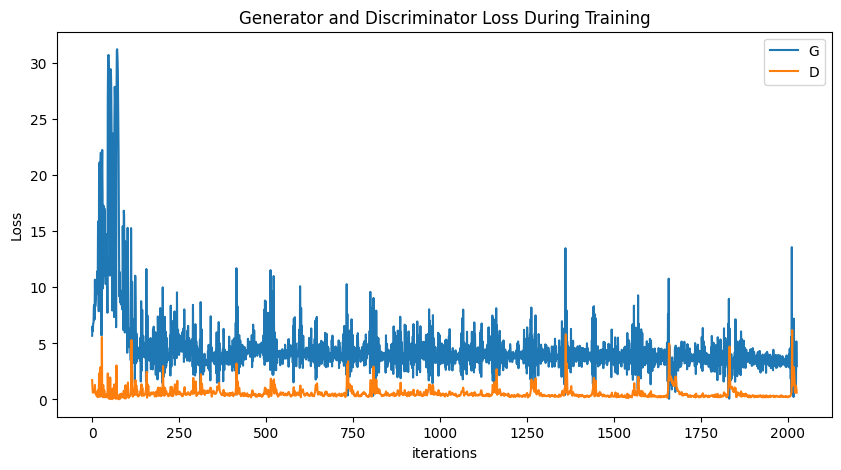

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

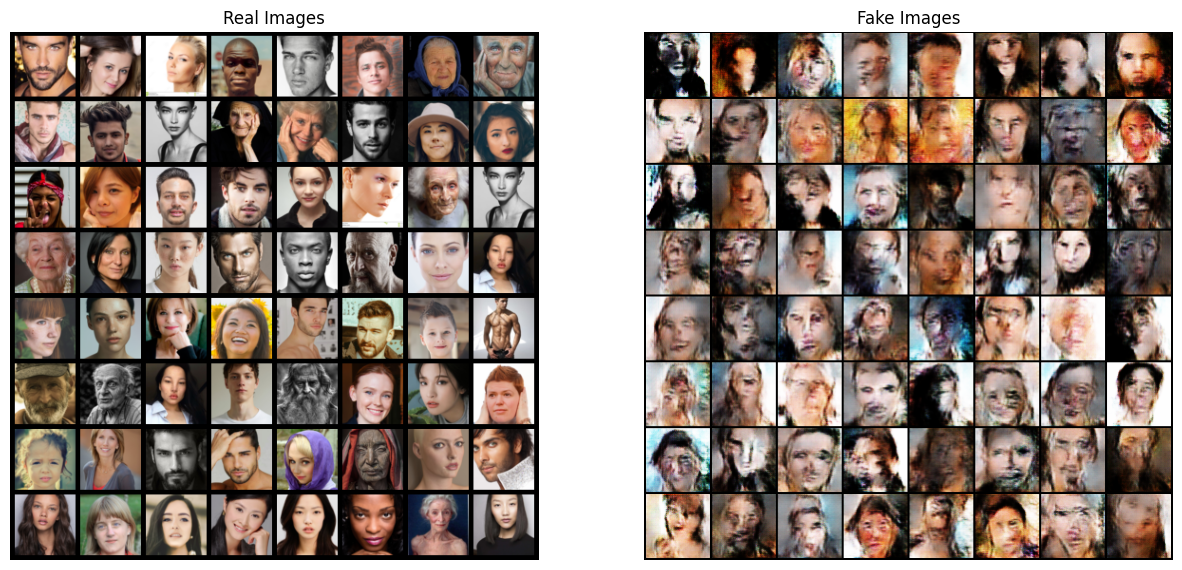

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()